### RAPID IO

This notebook shows how to route through problem definitions of the RAPID model

In [1]:
from pathlib import Path
import xtensor as xt
import diffhydro as dh
from diffhydro.io import read_rapid_graph

### Parameters

In [2]:
# Routing model parameters
max_delay = 32
dt = 1/24
device = "cuda:0"
root = Path("./data") # Set a data root path with enough disk space (>100MB)

### Download data if necessary

Downloads can take time, only execute this cell if you have not previously downloaded the data

In [3]:
from utils.download import download_single_vpu_data, download_rapid_config, process_single_vpu_data
#download_single_vpu_data(root)

### Simple routing workflow with RAPID IO

In [4]:
rapid_path = root / "geoglows" / "rapid_config" / "305"

##### Load routing input data:
- First create a routing graph RivTree from the config parameters in rapid_path and move this object to GPU
- Load the runoff time series from the netcdf, reshape it appropriately (into dimensions "batch", "spatial" and "time"), convert it to DataTensor and move this object to GPU

In [5]:
g = read_rapid_graph(rapid_path).to(device)

In [6]:
runoff = xt.open_datatensor(rapid_path / "runoff.nc")
runoff

DataTensor(shape=torch.Size([29220, 15562]), dims=('time', 'spatial'), coords=[time: 29220, spatial: 15562])

In [ ]:
runoff = runoff.expand_dims("batch")\
               .transpose("batch", "spatial", "time")\
               .to(device)

##### Instantiate the routing model

In [8]:
model = dh.LTIRouter(max_delay=max_delay, dt=dt).to(device)

##### Execute routing

In [9]:
discharges = model(runoff, g)
discharges

DataTensor(shape=torch.Size([1, 15562, 29220]), dims=('batch', 'spatial', 'time'), coords=[batch: 1, spatial: 15562, time: 29220])

##### Convert outputs to pandas (GPU->CPU transfer occurs) and inspect values

In [10]:
discharges = discharges.squeeze().to_pandas().T # Convert to pandas
discharges.head() # Plot outputs in m3/s

spatial,360001250,360001666,360004371,360004579,360002916,360003124,360003332,360004997,360005205,360007703,...,360041503,360041711,360041919,360049776,360049984,360050192,360061034,360047471,360048928,360048149
time,,,,,,,,,,,,,,,,,,,,,
1940-01-01,0.020617,0.026120,0.028604,0.027002,0.093730,0.083186,0.110525,0.109260,0.059938,0.056122,...,0.0,0.0,0.0,0.049833,0.037669,0.034605,0.0,0.024422,0.019204,0.0
1940-01-02,0.030191,0.041572,0.049144,0.048774,0.198441,0.195470,0.283672,0.285597,0.251374,0.272865,...,0.0,0.0,0.0,0.071679,0.066761,0.065450,0.0,0.039078,0.036584,0.0
1940-01-03,0.031068,0.044001,0.053228,0.053566,0.227763,0.229860,0.341315,0.345010,0.342599,0.386830,...,0.0,0.0,0.0,0.072236,0.072479,0.072452,0.0,0.043933,0.043190,0.0
1940-01-04,0.030905,0.043835,0.053101,0.053482,0.228770,0.231265,0.344633,0.348583,0.354901,0.405028,...,0.0,0.0,0.0,0.071405,0.071905,0.071947,0.0,0.041659,0.042223,0.0
1940-01-05,0.031162,0.044131,0.053389,0.053732,0.229566,0.231909,0.345685,0.349618,0.355812,0.406665,...,0.0,0.0,0.0,0.071561,0.071814,0.071795,0.0,0.041990,0.041838,0.0


##### Visualize outlet time series

<Axes: xlabel='time'>

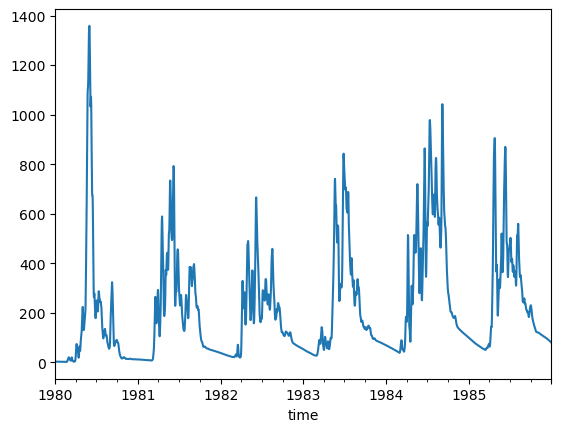

In [11]:
outlet_idx = discharges.sum().idxmax() # Identify outlet as the maximum discharge channel
discharges[outlet_idx]["1980":"1985"].plot()